## Time-domain modelling and inversion

In [53]:
# We first import the needed modules
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt  # submodule of pg
from pygimli.physics import ert  # subsubmodule
import pybert as pb

Data: Electrodes: 81 data: 1260
Mesh: Nodes: 926 Cells: 1694 Boundaries: 2619


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x236218c1490>)

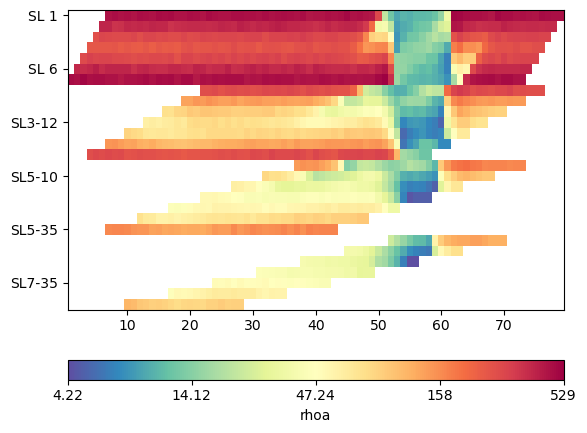

In [54]:
# We first load the synthetic model and data
data = ert.load("synth.dat")
print(data)
mesh = pg.load("synth.bms")
print(mesh)
pg.show(data)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2362172cbb0>)

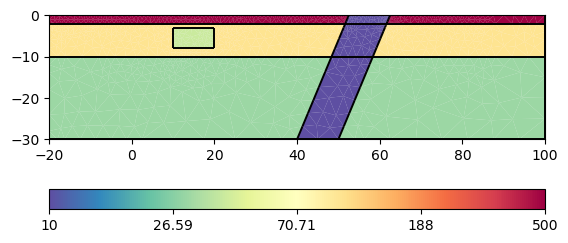

In [55]:
# Next, we are creating the IP forward response.
rhoVec = np.array([0, 500, 100, 30, 40, 10])[mesh.cellMarkers()]
pg.show(mesh, rhoVec, logScale=True, cMap="Spectral_r")

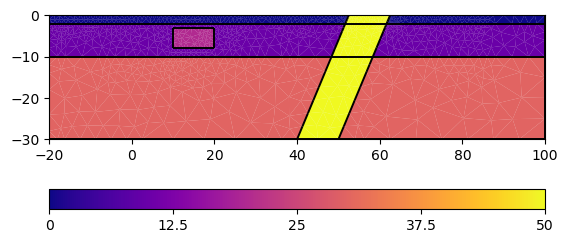

In [56]:
mVec = np.array([0, 0.0, 0.01, 0.03, 0.02, 0.05])[mesh.cellMarkers()]
ax, _ = pg.show(mesh, mVec*1000, cMap="plasma", cMin=0, cMax=50)

06/06/23 - 16:38:06 - pyGIMLi - INFO - Found 1 regions.
06/06/23 - 16:38:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/23 - 16:38:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/23 - 16:38:06 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3545 Cells: 6776 Boundaries: 5238
06/06/23 - 16:38:08 - pyGIMLi - INFO - Found 5 regions.
06/06/23 - 16:38:08 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)


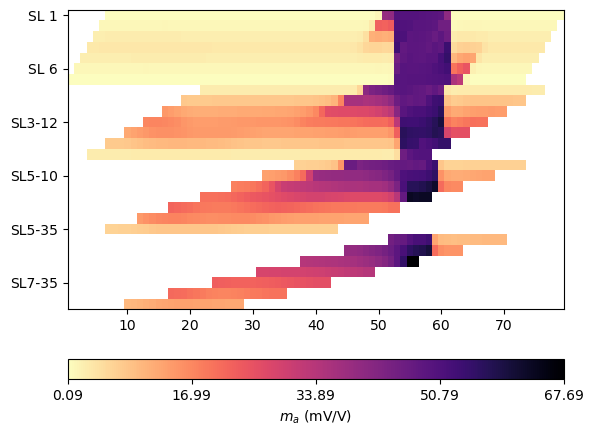

In [57]:
mesh0 = pg.Mesh(mesh)
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopDC = ert.ERTModelling()
fopDC.setMesh(mesh0)
fopDC.setData(data)
# data["rhoa"] = fopDC.response(rhoVec)
fopDC.createJacobian(rhoVec)
fopIP = pb.tdip.DCIPMModelling(fopDC, mesh, rhoVec)
data["ma"] = fopIP.response(mVec)
pg.show(data, data["ma"]*1000, logScale=False, label=r"$m_a$ (mV/V)", cMap="magma_r");


We first have to run and direct current (DC) inversion as we need the resistivity before we can do the IP inversion.

06/06/23 - 16:38:09 - pyGIMLi - INFO - Found 2 regions.
06/06/23 - 16:38:09 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/23 - 16:38:09 - pyGIMLi - INFO - Found 2 regions.
06/06/23 - 16:38:09 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/23 - 16:38:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/23 - 16:38:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/23 - 16:38:09 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3558 Cells: 6700 Boundaries: 5232
06/06/23 - 16:38:09 - pyGIMLi - INFO - Use median(data values)=125.6395316258325
06/06/23 - 16:38:09 - pyGIMLi - INFO - Created startmodel from forward operator: 1317 [125.6395316258325,...,125.6395316258325]


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2362152b6a0>)

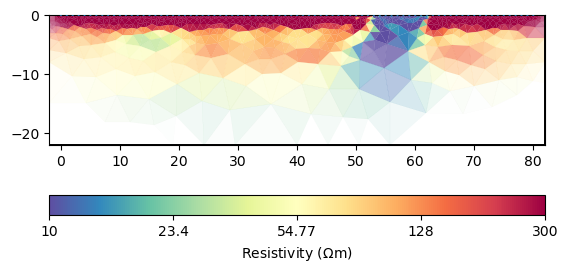

In [58]:
mgr = ert.Manager(data)
mgr.invert(zWeight=0.2, paraDepth=22)
mgr.showResult(cMin=10, cMax=300)

We setup a new modelling class and do an inversion by hand.

In [59]:
mesh0 = mgr.paraDomain
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopIP = pb.tdip.DCIPMModelling(mgr.fop, mesh0, mgr.model, response=mgr.inv.response)
fopIP.createRefinedForwardMesh(True)
invIP = pg.Inversion(fop=fopIP, verbose=True)
modelIP = invIP.run(data["ma"], absoluteError=0.001, relativeError=0.02, 
                    startModel=0.1, lam=20, zWeight=0.2, verbose=True)

06/06/23 - 16:38:31 - pyGIMLi - INFO - Found 1 regions.
06/06/23 - 16:38:31 - pyGIMLi - INFO - Starting inversion.


fop: <pybert.tdip.modelling.DCIPMModelling object at 0x00000236218A7680>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000236216A1DC0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000023621AEBD10>
min/max (data): 8.6e-05/0.07
min/max (error): 3.48%/1169%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 659.17 (dPhi = 88.28%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 79.75 (dPhi = 87.87%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 8.31 (dPhi = 89.02%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.08 (dPhi = 77.36%) lam: 20.0
----------------------------------------------------------------

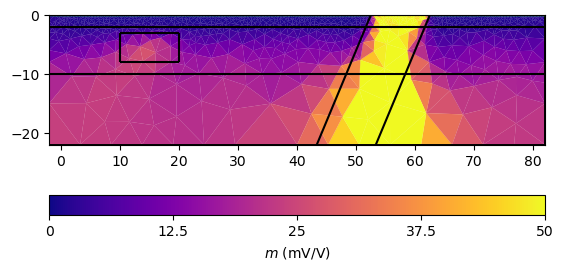

In [60]:
geo = mt.readPLC("geo.poly")
ax, cb = pg.show(mgr.paraDomain, modelIP*1000, logScale=False, label=r"$m$ (mV/V)", 
                 cMap="plasma", cMin=0, cMax=50)
pg.viewer.mpl.drawPLC(ax, geo, fitView=False, fillRegion=False)